In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

In [3]:
all_configs = []
with open(CHECK_DIR / 'exp1.jsonl', 'r') as f:
    json_str = f.read()
    json_objs = json_str.split('}\n')
    for json_obj in json_objs:
        if json_obj:
            all_configs.append(json.loads(json_obj + '}'))

JSONDecodeError: Extra data: line 2 column 15 (char 15)

In [4]:
all_configs

[{'data_dir': '/checkpoint/vivc/data/d8a6c146-1df7-4c08-abdf-575b5258fc57',
  'problem': 'parity',
  'n_len': 6,
  'split_probas': 0.5,
  'n_data_per_len': 2048,
  'zipf_offset': 0,
  'zipf_coef': 0,
  'emb_dim': 10,
  'emb_dropout': 0.1,
  'n_head': 1,
  'n_layer': 2,
  'n_epochs': 5000,
  'batch_size': 256,
  'learning_rate': 0.0003,
  'checkpoint_freq': 100,
  'overwrite_checkpoint': True,
  'load_checkpoint': False,
  'check_dir': '/checkpoint/vivc/models/d8a6c146-1df7-4c08-abdf-575b5258fc57',
  'full_eval': True,
  'eval_freq': 10},
 {'data_dir': '/checkpoint/vivc/data/590ad4e4-6c8d-4d48-ba65-45a90f53659c',
  'problem': 'parity',
  'n_len': 8,
  'split_probas': 0.5,
  'n_data_per_len': 2048,
  'zipf_offset': 0,
  'zipf_coef': 0,
  'emb_dim': 10,
  'emb_dropout': 0.1,
  'n_head': 1,
  'n_layer': 2,
  'n_epochs': 5000,
  'batch_size': 256,
  'learning_rate': 0.0003,
  'checkpoint_freq': 100,
  'overwrite_checkpoint': True,
  'load_checkpoint': False,
  'check_dir': '/checkpoint/vivc

In [5]:
X = np.array([8, 16, 32])
Y = np.array([32, 64, 128])

Z1_parity = np.full((len(X), len(Y)), -1, dtype=float)
Z2_parity = np.full((len(X), len(Y)), -1, dtype=float)
Z3_parity = np.full((len(X), len(Y)), -1, dtype=float)
Z4_parity = np.full((len(X), len(Y)), -1, dtype=float)
Z1_nocot =  np.full((len(X), len(Y)), -1, dtype=float)
Z2_nocot =  np.full((len(X), len(Y)), -1, dtype=float)
Z3_nocot =  np.full((len(X), len(Y)), -1, dtype=float)
Z4_nocot =  np.full((len(X), len(Y)), -1, dtype=float)
Z1_copy =   np.full((len(X), len(Y)), -1, dtype=float)
Z2_copy =   np.full((len(X), len(Y)), -1, dtype=float)
Z3_copy =   np.full((len(X), len(Y)), -1, dtype=float)
Z4_copy =   np.full((len(X), len(Y)), -1, dtype=float)


for config in all_configs:
    data_dir = Path(config['data_dir'])
    problem = config['problem']
    n_len = config['n_len']
    split_probas = config['split_probas']
    n_data_per_len = config['n_data_per_len']
    zipf_offset = config['zipf_offset']
    zipf_coef = config['zipf_coef']
    emb_dim = config['emb_dim']
    emb_dropout = config['emb_dropout']
    n_head = config['n_head']
    n_layer = config['n_layer']
    n_epochs = config['n_epochs']
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']
    check_dir = Path(config['check_dir'])
    eval_freq = config['eval_freq']
    checkpoint_freq = config['checkpoint_freq']
    overwrite_checkpoint = config['overwrite_checkpoint']
    load_checkpoint = config['load_checkpoint']

    # print(f"{n_len=}, {problem=}")

    if n_head != 1 or n_layer != 2:
        continue

    try:
        checkpoint = torch.load(check_dir / 'model.pth')
    except Exception as e:
        print("problem with", problem, emb_dim, n_len)
        continue

    timestamps = checkpoint['timestamps']
    ind = timestamps != -1
    timestamps = timestamps[ind]

    meaning = checkpoint['meaning']
    evals = checkpoint['evals'][ind]

    eval_dim = evals.shape[1] // 2
    train_evals = evals[:, :eval_dim]
    test_evals = evals[:, eval_dim:]

    min_len = 4
    nd_meaning = np.array(meaning)
    res = np.empty((2, n_len + 1 - min_len), dtype=float)
    for i, eval_prefix in enumerate(['attn0_peaky_thres', 'attn1_peaky_thres']):
        for j, length in enumerate(range(min_len, n_len+1)):
            eval_name = f"{eval_prefix}_{length}"

            ind = np.argmax(np.array(meaning) == eval_name)

            train_res = train_evals[-1, ind]
            test_res = test_evals[-1, ind]
            res[i, j] = test_res

    train_acc = train_evals[-1, min_len-1:n_len].mean()
    test_acc = train_evals[-1, min_len-1:n_len].mean()
    res = res.mean(axis=1)

    x = np.argmax(X == n_len)
    y = np.argmax(Y == emb_dim)
    if problem == 'parity':
        Z1_parity[x, y] = train_acc
        Z2_parity[x, y] = test_acc
        Z3_parity[x, y] = res[0]
        Z4_parity[x, y] = res[1]
    elif problem == 'no-cot':
        Z1_nocot[x, y] = train_acc
        Z2_nocot[x, y] = test_acc
        Z3_nocot[x, y] = res[0]
        Z4_nocot[x, y] = res[1]
    elif problem == 'binary-copy':
        Z1_copy[x, y] = train_acc
        Z2_copy[x, y] = test_acc
        Z3_copy[x, y] = res[0]
        Z4_copy[x, y] = res[1]
    else:
        break

problem with parity 11 30
problem with parity 29 26
problem with parity 47 22
problem with parity 65 18
problem with parity 83 14
problem with parity 101 10
problem with parity 119 6
problem with no-cot 16 30
problem with no-cot 34 26
problem with no-cot 52 22
problem with no-cot 70 18
problem with no-cot 88 14
problem with no-cot 106 10
problem with no-cot 124 6
problem with binary-copy 21 30
problem with binary-copy 39 26
problem with binary-copy 57 22
problem with binary-copy 75 18
problem with binary-copy 93 14
problem with binary-copy 111 10
problem with parity 73 31
problem with parity 93 29
problem with parity 40 18
problem with parity 80 26
problem with parity 18 29
problem with parity 68 29
problem with parity 69 29
problem with parity 55 30
problem with parity 73 26
problem with parity 91 22
problem with parity 109 18
problem with parity 127 14
problem with no-cot 25 10
problem with no-cot 43 6
problem with no-cot 60 30
problem with no-cot 78 26
problem with no-cot 96 22
prob

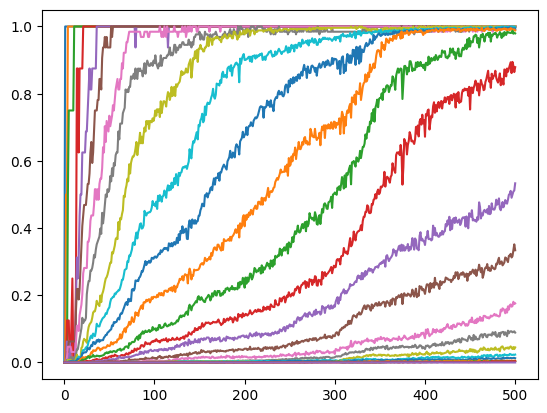

In [6]:
plt.plot(train_evals[:, :n_len])

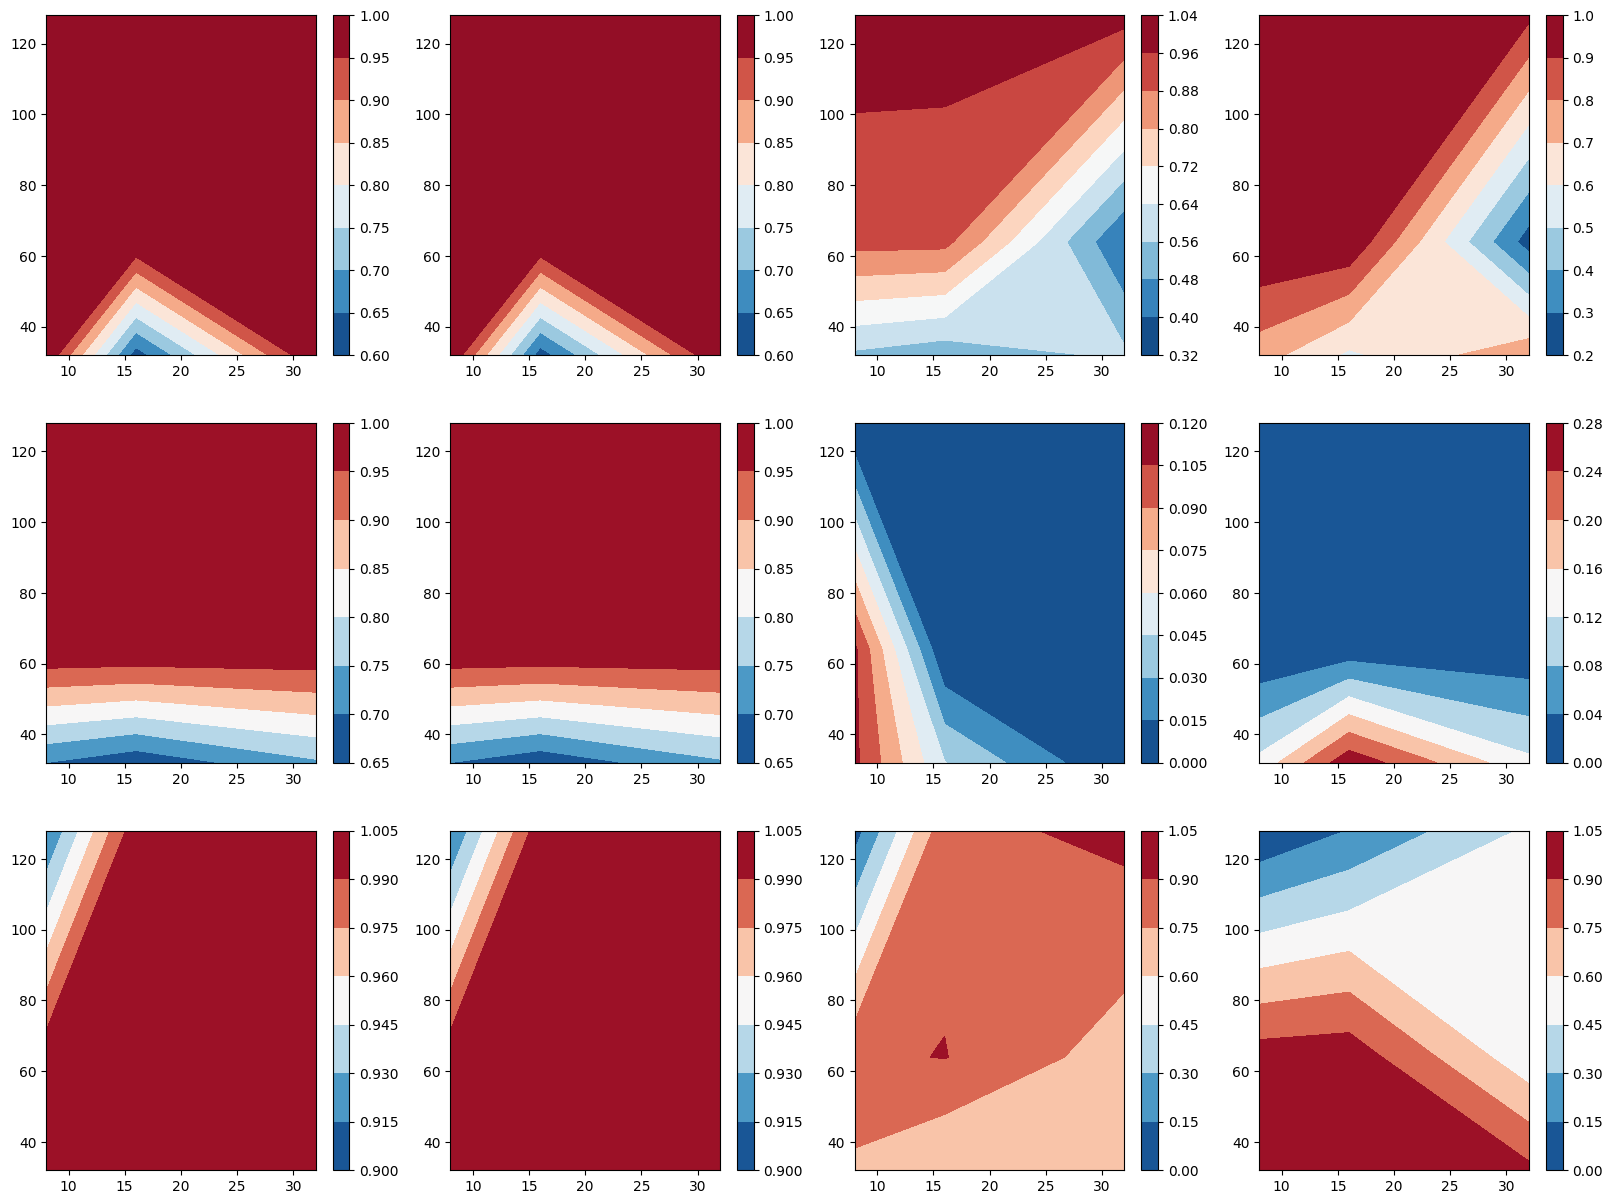

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
a00 = axes[0, 0].contourf(X, Y, Z1_parity, cmap='RdBu_r')
a01 = axes[0, 1].contourf(X, Y, Z2_parity, cmap='RdBu_r')
a02 = axes[0, 2].contourf(X, Y, Z3_parity, cmap='RdBu_r')
a03 = axes[0, 3].contourf(X, Y, Z4_parity, cmap='RdBu_r')
a10 = axes[1, 0].contourf(X, Y, Z1_nocot , cmap='RdBu_r')
a11 = axes[1, 1].contourf(X, Y, Z2_nocot , cmap='RdBu_r')
a12 = axes[1, 2].contourf(X, Y, Z3_nocot , cmap='RdBu_r')
a13 = axes[1, 3].contourf(X, Y, Z4_nocot , cmap='RdBu_r')
a20 = axes[2, 0].contourf(X, Y, Z1_copy  , cmap='RdBu_r')
a21 = axes[2, 1].contourf(X, Y, Z2_copy  , cmap='RdBu_r')
a22 = axes[2, 2].contourf(X, Y, Z3_copy  , cmap='RdBu_r')
a23 = axes[2, 3].contourf(X, Y, Z4_copy  , cmap='RdBu_r')
fig.colorbar(a00)
fig.colorbar(a01)
fig.colorbar(a02)
fig.colorbar(a03)
fig.colorbar(a10)
fig.colorbar(a11)
fig.colorbar(a12)
fig.colorbar(a13)
fig.colorbar(a20)
fig.colorbar(a21)
fig.colorbar(a22)
fig.colorbar(a23)